In [21]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import os
from sklearn.preprocessing import normalize


In [2]:
# Set the paths to your train and test directories
train_data_dir = '/content/drive/MyDrive/assign_classification/train'
test_data_dir = '/content/drive/MyDrive/assign_classification/test'

In [3]:
# Define data transformations with augmentation for training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
# Define data transformations for testing
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [5]:
# Load the datasets using ImageFolder
train_dataset = datasets.ImageFolder(train_data_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_data_dir, transform=test_transform)

In [6]:
# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
# Define a ResNet model
class ResNetModel(nn.Module):
    def __init__(self, num_classes):
        super(ResNetModel, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [8]:
# Instantiate the model
num_classes = len(train_dataset.classes)
model = ResNetModel(num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 133MB/s]


In [9]:
# Set up optimizer and learning rate scheduler
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [10]:
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNetModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [11]:
#Training loop
num_epochs = 10
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Adjust learning rate
    scheduler.step()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}')

Epoch 1/10, Loss: 0.8061
Epoch 2/10, Loss: 0.5497
Epoch 3/10, Loss: 0.3124
Epoch 4/10, Loss: 0.4880
Epoch 5/10, Loss: 0.2432
Epoch 6/10, Loss: 0.1196
Epoch 7/10, Loss: 0.2237
Epoch 8/10, Loss: 0.1574
Epoch 9/10, Loss: 0.0820
Epoch 10/10, Loss: 0.1533


In [12]:
# Evaluation
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
# Define a function to get predictions and probabilities
def get_predictions(loader):
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probabilities)

    return all_preds, all_probs

In [28]:
# Function to get classification metrics
def get_metrics(true_labels, predicted_probs, num_classes):
    # Convert predicted_probs to a NumPy array
    predicted_probs = np.array(predicted_probs)

    # Get class indices for the classes in the dataset
    class_indices = [train_dataset.class_to_idx[class_name] for class_name in train_dataset.classes]

    # Modify predicted_probs array to include only the classes present in the dataset
    predicted_probs_for_classes = predicted_probs[:, class_indices]

    # Normalize predicted_probs
    predicted_probs_for_classes = normalize(predicted_probs_for_classes, axis=1, norm='l1')

    # Get predicted labels
    predicted_labels = predicted_probs.argmax(axis=1)

    # Calculate ROC AUC for the classes
    roc_auc = roc_auc_score(true_labels, predicted_probs_for_classes, multi_class='ovr')

    # Confusion Matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Calculate precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average=None)

    return precision, recall, f1, roc_auc, conf_matrix


In [30]:
# Function to find the best confidence threshold for each class
def find_best_thresholds(true_labels, predicted_probs, num_classes):
    thresholds = []

    # Convert predicted probabilities to a NumPy array
    probabilities = np.array(predicted_probs)

    # Iterate over each class
    for class_index in range(num_classes):
        # Get probabilities for the current class
        class_probs = probabilities[:, class_index]

        # Generate a range of thresholds
        threshold_range = np.linspace(0, 1, 100)

        # Calculate F1-score for each threshold
        f1_scores = []
        for threshold in threshold_range:
            predicted_labels = (class_probs > threshold).astype(int)
            _, _, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average=None)
            f1_scores.append(f1[class_index])

        # Find the threshold with the highest F1-score
        best_threshold = threshold_range[np.argmax(f1_scores)]
        thresholds.append(best_threshold)

    return thresholds

In [31]:
# Assuming you have a test_loader defined
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [32]:
# Get true labels and predicted probabilities
true_labels, predicted_probs = get_predictions(test_loader)

In [33]:
# Get classification metrics
precision, recall, f1, roc_auc, conf_matrix = get_metrics(true_labels, predicted_probs, num_classes)


In [34]:
# Find Best Confidence Threshold for Each Class
best_thresholds = find_best_thresholds(true_labels, predicted_probs, num_classes)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [35]:
# Print and visualize metrics
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC Score: {roc_auc}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Best Confidence Thresholds: {best_thresholds}')

Precision: [1. 1. 1.]
Recall: [1. 1. 1.]
F1 Score: [1. 1. 1.]
ROC AUC Score: 1.0
Confusion Matrix:
[[9 0 0]
 [0 9 0]
 [0 0 7]]
Best Confidence Thresholds: [1.0, 0.18181818181818182, 0.0]


In [36]:
# Save the trained model
torch.save(model.state_dict(), 'Vehicle classification1.pth')


In [45]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load a pre-trained model (e.g., ResNet50)
model = models.resnet50(pretrained=True)
model.eval()

# Define a function to visualize filters in a given layer
def visualize_filters(model, layer_num):
    # Check if the layer is the initial convolution block
    if layer_num == 0:
        layer = model.conv1
    else:
        layer = model.layer4[layer_num - 1].conv2

    # Extract the weights (filters) from the layer
    filters = layer.weight.data.cpu().numpy()

    # Normalize filters for visualization
    filters = (filters - filters.min()) / (filters.max() - filters.min())

    # Plot the filters
    n_filters = filters.shape[0]
    fig, axes = plt.subplots(1, n_filters, figsize=(15, 5))
    for i in range(n_filters):
        axes[i].imshow(filters[i, 0, :, :], cmap='viridis')
        axes[i].axis('off')
    plt.show()

# Define a function to visualize feature maps for a given layer
def visualize_feature_maps(model, layer_num, img_path):
    # Load and preprocess the image
    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = transform(img).unsqueeze(0)

    # Get the specified layer
    if layer_num == 0:
        layer = model.conv1
    else:
        layer = model.layer4[layer_num - 1].conv2

    # Register a forward hook to get the feature maps
    activation = {}
    def hook(module, input, output):
        activation['value'] = output.detach()
    hook_handle = layer.register_forward_hook(hook)

    # Forward pass to get the feature maps
    with torch.no_grad():
        model(img_tensor)

    # Remove the hook
    hook_handle.remove()

    # Extract the feature maps
    feature_maps = activation['value'].squeeze().cpu().numpy()

    # Plot the feature maps
    n_feature_maps = feature_maps.shape[0]
    fig, axes = plt.subplots(1, n_feature_maps, figsize=(15, 5))
    for i in range(n_feature_maps):
        axes[i].imshow(feature_maps[i, :, :], cmap='viridis')
        axes[i].axis('off')
    plt.show()




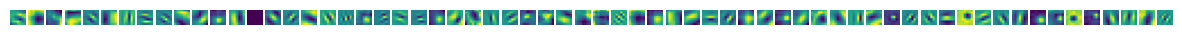

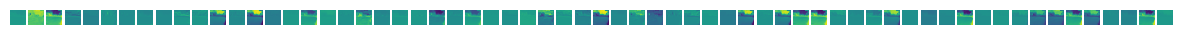

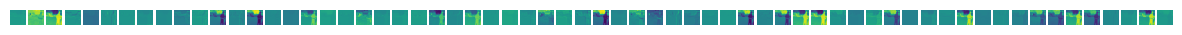

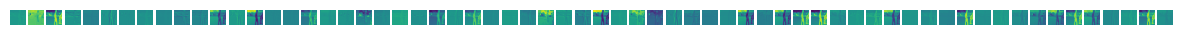

In [46]:
# Example usage:
# Visualize filters in the initial convolution block
visualize_filters(model, layer_num=0)

# Visualize feature maps for the initial convolution block using example images
img_path_class_1 = '/content/drive/MyDrive/assign_classification/train/bike/pfva_dataset_file_G_18082023_125843_8.jpg'   # Image actual path of each class
img_path_class_2 = '/content/drive/MyDrive/assign_classification/train/car/pfva_dataset_file_G_18082023_125843_19.jpg'  # Image actual path of each class
img_path_class_3 = '/content/drive/MyDrive/assign_classification/train/others/pfva_dataset_file_G_18082023_130713_8.jpg'   # Image actual path of each class
visualize_feature_maps(model, layer_num=0, img_path=img_path_class_1)
visualize_feature_maps(model, layer_num=0, img_path=img_path_class_2)
visualize_feature_maps(model, layer_num=0, img_path=img_path_class_3)

In [47]:
image, label = test_dataset[3]

In [39]:
from PIL import Image
import numpy as np

# Load and preprocess the image
img_path = '/content/drive/MyDrive/assign_classification/test/bike/pfva_dataset_file_G_18082023_132113_22.jpg'
image = Image.open(img_path).convert("RGB")

# Convert the image to a NumPy array
image_np = np.array(image)

# Convert the NumPy array to a PyTorch tensor
image = torch.from_numpy(image_np).permute(2, 0, 1).float() / 255.0

# Add batch dimension
image = image.unsqueeze(0)

# Move the image to the device (GPU if available)
image = image.to(device)

# Perform prediction
with torch.no_grad():
    output = model(image)


In [40]:
# Get predicted label
_, predicted = torch.max(output, 1)
predicted_label = predicted.item()

In [41]:
# Get class names
class_names = test_dataset.classes

In [42]:
# Denormalize and convert the PyTorch tensor to a NumPy array for display
image = image.squeeze().permute(1, 2, 0).detach().cpu().numpy()
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image = std * image + mean
image = np.clip(image, 0, 1)

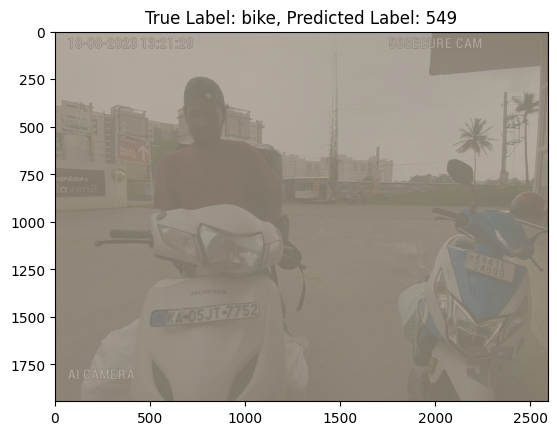

In [43]:
plt.imshow(image)
plt.title(f'True Label: {class_names[label]}, Predicted Label: {predicted_label}')
plt.show()
